# Linear Regression

In [4]:
from itertools import combinations
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf, pacf
from tqdm import tqdm

from utils import get_rmse, plot_series, plot_sortie_acf,\
    timeseries_train_test_split, add_lag_features, \
        process_subset, forward, backward, feature_selection

Some constants

In [5]:
FEATURES_TOT = [
    # 'Date et heure de comptage',
    # 'Lag_7_deb',
    # 'Lag_7_taux',
    'Jour férié',
    'Jour de la semaine_0', 'Jour de la semaine_1', 'Jour de la semaine_2', 'Jour de la semaine_3',
    'Jour de la semaine_4', 'Jour de la semaine_5', 'Jour de la semaine_6',
    'totalSnow_cm',
    'uvIndex',
    'tempC',
    'windspeedKmph',
    'precipMM',
    'humidity',
    'cloudcover',
    'is_day',
    'paris_repsire',
    'perturbation_travaux',
    'Prix du carburant'
]
FEATURES_TOT_DEB = FEATURES_TOT + ['Lag_7_D']
FEATURES_TOT_TAUX = FEATURES_TOT + ['Lag_7_T']

VARIABLES = ['Débit horaire', "Taux d'occupation"]

Loading entire DataFrame

In [6]:
whole_df = pd.read_csv("/Users/cha/Desktop/Code/eCSpress/data/final_data.csv", sep=";")
# Drop useless column
whole_df.drop('Unnamed: 0', inplace=True, axis=1)
# Dates
whole_df['Date et heure de comptage'] = pd.to_datetime(whole_df['Date et heure de comptage'], format='%Y-%m-%d %H:%M:%S')

print("len whole df", len(whole_df))
whole_df.head(2)

len whole df 27548


,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Etat arc_Barré,Etat arc_Invalide,Jour férié,Jour de la semaine_0,Jour de la semaine_1,...,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,is_day,paris_repsire,perturbation_travaux,Prix du carburant
0,AV_Champs_Elysees,2022-01-01 11:00:00,524.0,8.85667,1,0,1,1,0,0,...,4,12,8,11,16,11,True,False,0.0,1.691
1,AV_Champs_Elysees,2022-01-01 07:00:00,491.0,7.71611,1,0,1,1,0,0,...,9,9,8,8,16,8,False,False,0.0,1.691


Creation of DataFrames for each street

In [7]:
# Champs Elysees
ce_df = whole_df[whole_df['Libelle']=="AV_Champs_Elysees"]
ce_df = ce_df.sort_values(by='Date et heure de comptage')
ce_df = ce_df.reset_index(drop=True)
ce_df = ce_df.set_index('Date et heure de comptage')
ce_df = ce_df.asfreq('H', method= 'ffill')

# Saint Pères
peres_df = whole_df[whole_df['Libelle']=="Sts_Peres"]
peres_df = peres_df.sort_values(by='Date et heure de comptage')
peres_df = peres_df.reset_index(drop=True)
peres_df = peres_df.set_index('Date et heure de comptage')
peres_df = peres_df.asfreq('H', method= 'ffill')

# Convention
convention_df = whole_df[whole_df['Libelle']=="Convention"]
convention_df = convention_df.sort_values(by='Date et heure de comptage')
convention_df = convention_df.reset_index(drop=True)
convention_df = convention_df.set_index('Date et heure de comptage')
convention_df = convention_df.asfreq('H', method= 'ffill')

print('len CE', len(ce_df))
ce_df.head(1)

len CE 9549


,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Etat arc_Barré,Etat arc_Invalide,Jour férié,Jour de la semaine_0,Jour de la semaine_1,Jour de la semaine_2,...,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,is_day,paris_repsire,perturbation_travaux,Prix du carburant
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2021-11-01 04:00:00,AV_Champs_Elysees,1222.0,42.87945,3,0,1,1,1,0,0,...,29,10,7,8,28,8,False,False,0.0,1.5904


Adding lags to DataFrames

In [8]:
# Champs Elysees
ce_deb, LAG_FEAT_DEB = add_lag_features(ce_df, VARIABLES[0])
ce_taux, LAG_FEAT_TAUX = add_lag_features(ce_df, VARIABLES[1])

# Saints Pères
peres_deb, _ = add_lag_features(peres_df, VARIABLES[0])
peres_taux, _ = add_lag_features(peres_df, VARIABLES[1])

# Convention
convention_deb, _ = add_lag_features(convention_df, VARIABLES[0])
convention_taux, _ = add_lag_features(convention_df, VARIABLES[1])

print(len(ce_deb))
ce_deb.head(2)

9381


,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Etat arc_Barré,Etat arc_Invalide,Jour férié,Jour de la semaine_0,Jour de la semaine_1,Jour de la semaine_2,...,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,is_day,paris_repsire,perturbation_travaux,Prix du carburant,Lag_7_D
0,AV_Champs_Elysees,211.0,2.60278,1,0,1,0,1,0,0,...,10,2,9,14,9,False,False,0.0,1.591667,1222.0
1,AV_Champs_Elysees,193.0,2.33667,1,0,1,0,1,0,0,...,10,2,8,14,8,False,False,0.0,1.591667,1033.0


# Forward - Backward subset selection

In [9]:
lr_results = pd.DataFrame(columns=["Street", "Variable", "Features", "RMSE"], index = range(1, 7))

## Convention

### Convention - Débit horaire

BACKWARD


20it [00:01, 11.65it/s]
19it [00:00, 21.23it/s]
18it [00:00, 31.30it/s]
17it [00:00, 31.00it/s]
16it [00:00, 34.61it/s]
15it [00:00, 32.18it/s]
14it [00:00, 51.81it/s]
13it [00:00, 93.88it/s]
12it [00:00, 65.38it/s]
11it [00:00, 56.86it/s]
10it [00:00, 106.39it/s]
9it [00:00, 156.43it/s]
8it [00:00, 134.71it/s]
7it [00:00, 421.20it/s]
6it [00:00, 470.92it/s]
5it [00:00, 521.69it/s]
4it [00:00, 527.57it/s]
3it [00:00, 505.64it/s]
2it [00:00, 264.62it/s]


FOREWARD


100%|██████████| 20/20 [00:01<00:00, 10.55it/s]


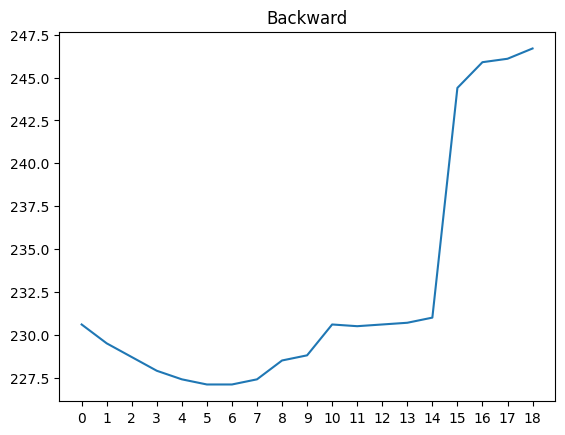

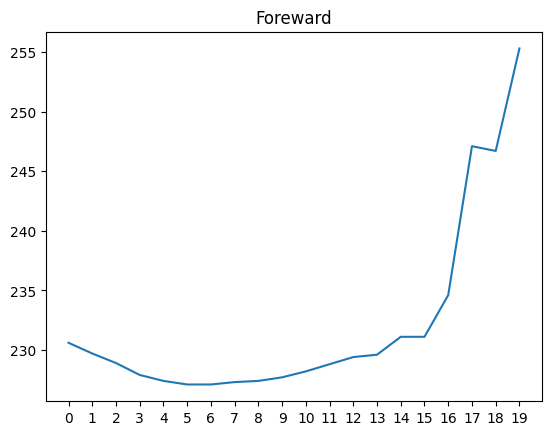

In [10]:
rue = "Convention"
variable = VARIABLES[0]
all_features = FEATURES_TOT_DEB.copy()
df = convention_deb.copy()

models_fwd_conv_deb, models_bwd_conv_deb = feature_selection(df, variable, all_features)

In [11]:
ind = 6

print(models_fwd_conv_deb.loc[ind]["Features"])
print(models_bwd_conv_deb.loc[ind]["Features"], "\n")
features_selected_conv_deb = models_bwd_conv_deb.loc[ind]["Features"]
RMSE = models_bwd_conv_deb.loc[ind]["RMSE"]
print("RMSE", RMSE)
print(features_selected_conv_deb)

lr_results.loc[1] = {
    "Street": rue,
    "Variable": variable,
    "Features": features_selected_conv_deb,
    "RMSE":RMSE,
}

['uvIndex', 'Jour de la semaine_3', 'humidity', 'Jour férié', 'Jour de la semaine_4', 'tempC']
('Jour férié', 'Jour de la semaine_3', 'Jour de la semaine_4', 'uvIndex', 'tempC', 'humidity') 

RMSE 227.1
('Jour férié', 'Jour de la semaine_3', 'Jour de la semaine_4', 'uvIndex', 'tempC', 'humidity')


### Convention - Taux d'occupation

BACKWARD


20it [00:01, 16.93it/s]
19it [00:00, 19.80it/s]
18it [00:00, 27.35it/s]
17it [00:00, 31.55it/s]
16it [00:00, 44.32it/s]
15it [00:00, 36.73it/s]
14it [00:00, 55.27it/s]
13it [00:00, 66.14it/s]
12it [00:00, 68.40it/s]
11it [00:00, 66.31it/s]
10it [00:00, 215.58it/s]
9it [00:00, 229.40it/s]
8it [00:00, 178.90it/s]
7it [00:00, 267.71it/s]
6it [00:00, 157.68it/s]
5it [00:00, 321.50it/s]
4it [00:00, 540.90it/s]
3it [00:00, 428.98it/s]
2it [00:00, 557.42it/s]


FOREWARD


100%|██████████| 20/20 [00:01<00:00, 10.45it/s]


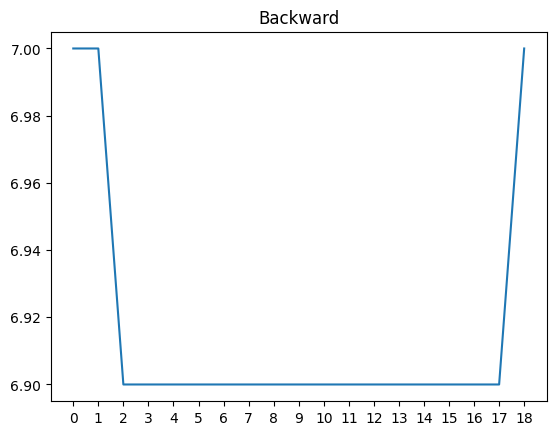

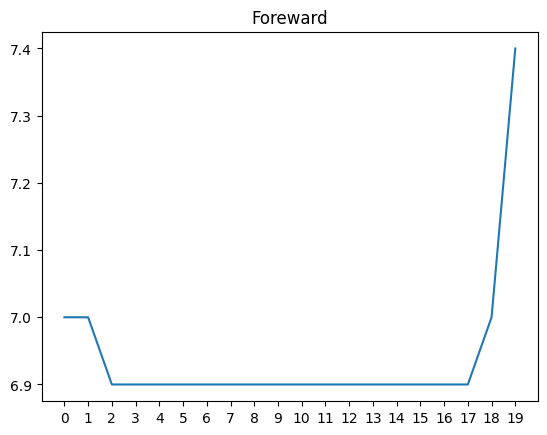

In [12]:
rue = "Convention"
variable = VARIABLES[1]
all_features = FEATURES_TOT_TAUX.copy()
df = convention_taux.copy()

models_fwd_conv_taux, models_bwd_conv_taux = feature_selection(df, variable, all_features)

In [13]:
ind = 3

print(models_fwd_conv_taux.loc[ind]["Features"])
print(models_bwd_conv_taux.loc[ind]["Features"], "\n")
features_selected_conv_taux = models_fwd_conv_taux.loc[ind]["Features"]
print("RMSE", models_fwd_conv_taux.loc[ind]["RMSE"])
print(features_selected_conv_taux)

lr_results.loc[2] = {
    "Street": rue,
    "Variable": variable,
    "Features": features_selected_conv_taux,
    "RMSE": models_fwd_conv_taux.loc[ind]["RMSE"],
}

['Lag_7_T', 'Jour férié', 'Jour de la semaine_3']
('Jour férié', 'Jour de la semaine_3', 'Lag_7_T') 

RMSE 6.9
['Lag_7_T', 'Jour férié', 'Jour de la semaine_3']


## Saint Pères

### Saint Pères - Débit Horaire

BACKWARD


20it [00:00, 20.42it/s]
19it [00:01, 18.10it/s]
18it [00:00, 33.75it/s]
17it [00:00, 35.24it/s]
16it [00:00, 33.94it/s]
15it [00:00, 31.86it/s]
14it [00:00, 52.81it/s]
13it [00:00, 77.83it/s]
12it [00:00, 36.00it/s]
11it [00:00, 79.05it/s]
10it [00:00, 201.35it/s]
9it [00:00, 212.56it/s]
8it [00:00, 271.53it/s]
7it [00:00, 207.56it/s]
6it [00:00, 536.34it/s]
5it [00:00, 281.37it/s]
4it [00:00, 159.13it/s]
3it [00:00, 361.32it/s]
2it [00:00, 452.58it/s]


FOREWARD


100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


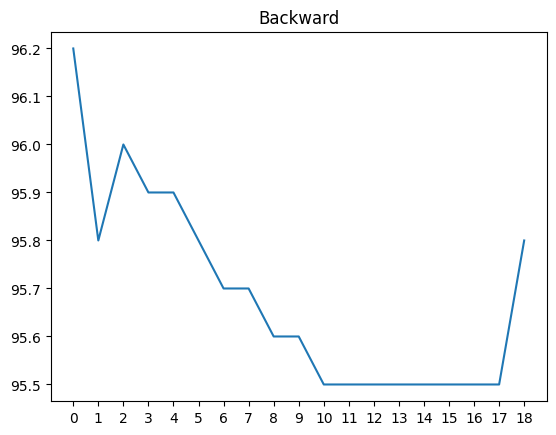

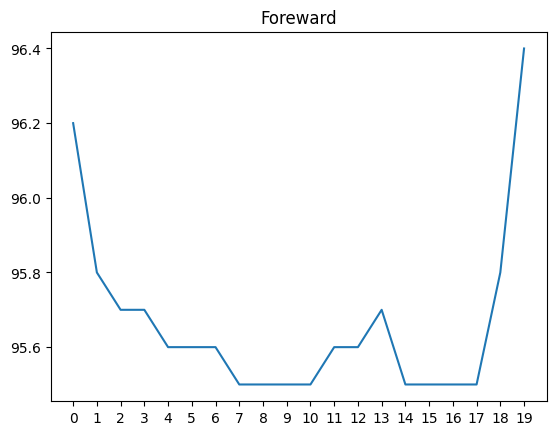

In [14]:
rue = "Saint Pères"
variable = VARIABLES[0]
all_features = FEATURES_TOT_DEB.copy()
df = peres_deb.copy()

models_fwd_peres_deb, models_bwd_peres_deb = feature_selection(df, variable, all_features)

In [15]:
ind = 11

print(models_fwd_peres_deb.loc[ind]["Features"])
print(models_bwd_peres_deb.loc[ind]["Features"], "\n")
features_selected_peres_deb = models_bwd_peres_deb.loc[ind]["Features"]
print("RMSE", models_bwd_peres_deb.loc[ind]["RMSE"])
print(features_selected_peres_deb)

lr_results.loc[3] = {
    "Street": rue,
    "Variable": variable,
    "Features": features_selected_peres_deb,
    "RMSE": models_bwd_peres_deb.loc[ind]["RMSE"],
}

['Lag_7_D', 'is_day', 'uvIndex', 'Jour de la semaine_0', 'Jour de la semaine_3', 'Jour de la semaine_2', 'totalSnow_cm', 'windspeedKmph', 'precipMM', 'Jour de la semaine_1', 'perturbation_travaux']
('Jour férié', 'Jour de la semaine_1', 'Jour de la semaine_2', 'Jour de la semaine_3', 'Jour de la semaine_4', 'totalSnow_cm', 'uvIndex', 'windspeedKmph', 'precipMM', 'is_day', 'Lag_7_D') 

RMSE 95.5
('Jour férié', 'Jour de la semaine_1', 'Jour de la semaine_2', 'Jour de la semaine_3', 'Jour de la semaine_4', 'totalSnow_cm', 'uvIndex', 'windspeedKmph', 'precipMM', 'is_day', 'Lag_7_D')


### Saint Pères - Taux d'occupation

BACKWARD


20it [00:01, 14.83it/s]
19it [00:01, 13.41it/s]
18it [00:00, 26.90it/s]
17it [00:00, 34.32it/s]
16it [00:00, 30.42it/s]
15it [00:00, 38.80it/s]
14it [00:00, 52.40it/s]
13it [00:00, 72.62it/s]
12it [00:00, 73.62it/s]
11it [00:00, 83.30it/s]
10it [00:00, 236.14it/s]
9it [00:00, 140.90it/s]
8it [00:00, 252.63it/s]
7it [00:00, 276.92it/s]
6it [00:00, 323.57it/s]
5it [00:00, 237.49it/s]
4it [00:00, 219.66it/s]
3it [00:00, 551.57it/s]
2it [00:00, 573.58it/s]


FOREWARD


100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


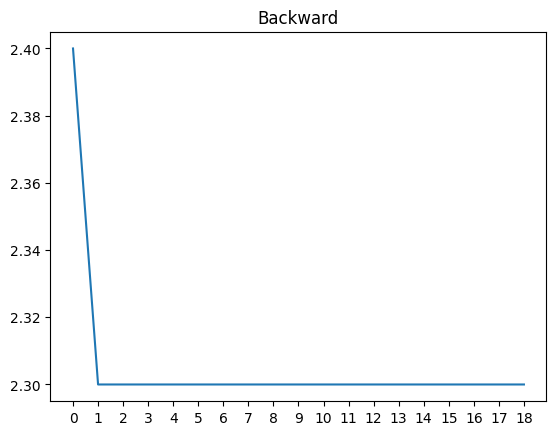

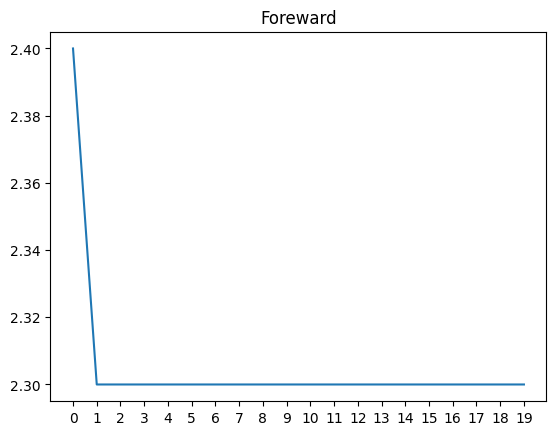

In [16]:
rue = "Saint Pères"
variable = VARIABLES[1]
all_features = FEATURES_TOT_TAUX.copy()
df = peres_taux.copy()

models_fwd_peres_taux, models_bwd_peres_taux = feature_selection(df, variable, all_features)

In [17]:
ind = 2

print(models_fwd_peres_taux.loc[ind]["Features"])
print(models_bwd_peres_taux.loc[ind]["Features"], "\n")

features_selected_peres_taux = models_fwd_peres_taux.loc[ind]["Features"]
print("RMSE", models_fwd_peres_taux.loc[ind]["RMSE"])
print(features_selected_peres_taux)

lr_results.loc[4] = {
    "Street": rue,
    "Variable": variable,
    "Features": features_selected_peres_taux,
    "RMSE": models_fwd_peres_taux.loc[ind]["RMSE"],
}

['Lag_7_T', 'windspeedKmph']
('windspeedKmph', 'Lag_7_T') 

RMSE 2.3
['Lag_7_T', 'windspeedKmph']


## Champs Elysees

### Champs Elysees - Débit Horaire

BACKWARD


20it [00:01, 12.67it/s]
19it [00:00, 19.39it/s]
18it [00:00, 32.44it/s]
17it [00:00, 28.30it/s]
16it [00:00, 26.88it/s]
15it [00:00, 29.82it/s]
14it [00:00, 53.59it/s]
13it [00:00, 71.47it/s]
12it [00:00, 80.05it/s]
11it [00:00, 59.80it/s]
10it [00:00, 163.99it/s]
9it [00:00, 189.40it/s]
8it [00:00, 199.23it/s]
7it [00:00, 156.70it/s]
6it [00:00, 260.28it/s]
5it [00:00, 361.54it/s]
4it [00:00, 365.06it/s]
3it [00:00, 484.03it/s]
2it [00:00, 530.09it/s]


FOREWARD


100%|██████████| 20/20 [00:01<00:00, 13.21it/s]


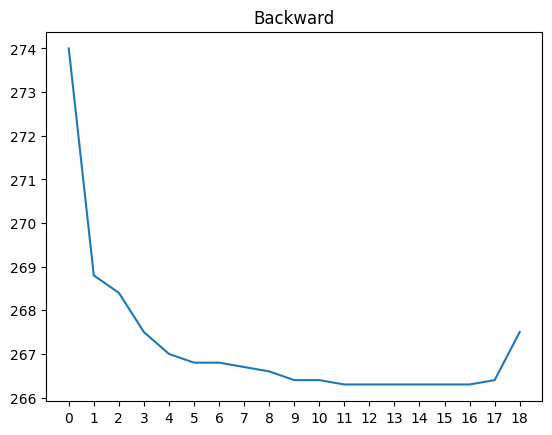

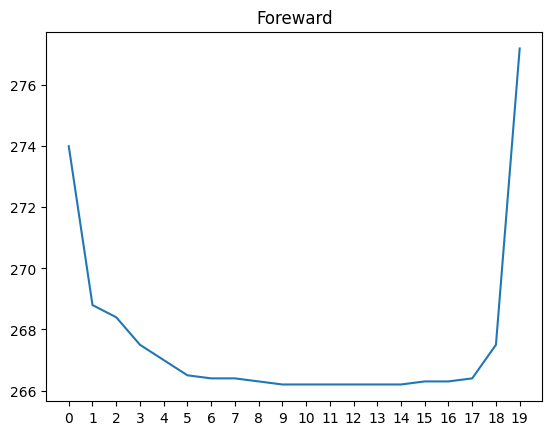

In [18]:
rue = "Champs Elysees"
variable = VARIABLES[0]
all_features = FEATURES_TOT_DEB.copy()
df = ce_deb.copy()

models_fwd_ce_deb, models_bwd_ce_deb = feature_selection(df, variable, all_features)

In [19]:
ind = 6

print(models_fwd_ce_deb.loc[ind]["Features"])
print(models_bwd_ce_deb.loc[ind]["Features"], "\n")
features_selected_ce_deb = models_bwd_ce_deb.loc[ind]["Features"]
print("RMSE", models_bwd_ce_deb.loc[ind]["RMSE"])
print(features_selected_ce_deb)

lr_results.loc[5] = {
    "Street": rue,
    "Variable": variable,
    "Features": features_selected_ce_deb,
    "RMSE": models_bwd_ce_deb.loc[ind]["RMSE"],
}

['Lag_7_D', 'is_day', 'uvIndex', 'humidity', 'Prix du carburant', 'Jour de la semaine_6']
('Jour de la semaine_4', 'uvIndex', 'humidity', 'is_day', 'Prix du carburant', 'Lag_7_D') 

RMSE 266.8
('Jour de la semaine_4', 'uvIndex', 'humidity', 'is_day', 'Prix du carburant', 'Lag_7_D')


### Champs Elysees - Taux d'occupation

BACKWARD


20it [00:01, 17.18it/s]
19it [00:00, 21.50it/s]
18it [00:00, 22.58it/s]
17it [00:00, 20.39it/s]
16it [00:00, 28.62it/s]
15it [00:00, 37.47it/s]
14it [00:00, 39.80it/s]
13it [00:00, 64.34it/s]
12it [00:00, 71.96it/s]
11it [00:00, 60.00it/s]
10it [00:00, 205.23it/s]
9it [00:00, 144.95it/s]
8it [00:00, 191.99it/s]
7it [00:00, 138.22it/s]
6it [00:00, 318.10it/s]
5it [00:00, 458.71it/s]
4it [00:00, 505.38it/s]
3it [00:00, 402.95it/s]
2it [00:00, 564.97it/s]


FOREWARD


100%|██████████| 20/20 [00:01<00:00, 12.23it/s]


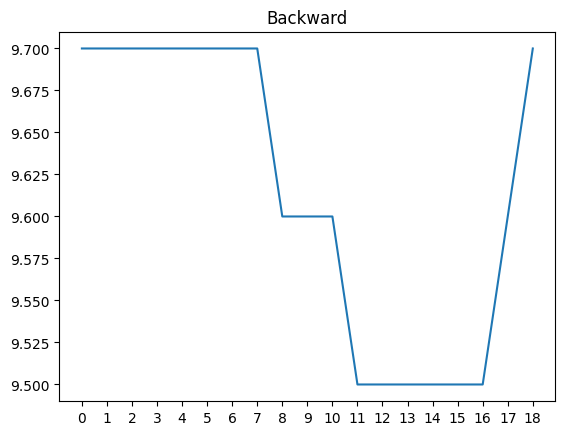

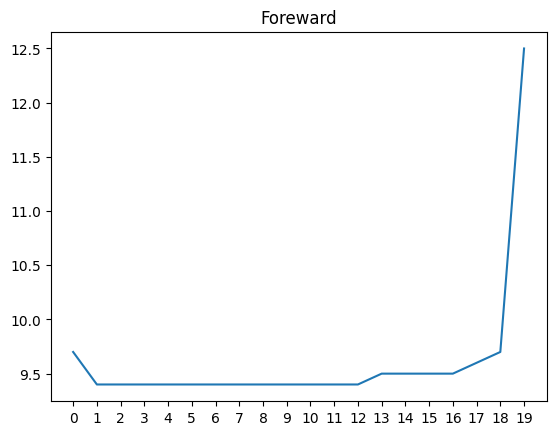

In [20]:
rue = "Champs Elysees"
variable = VARIABLES[1]
all_features = FEATURES_TOT_TAUX.copy()
df = ce_taux.copy()

models_fwd_ce_taux, models_bwd_ce_taux = feature_selection(df, variable, all_features)

In [21]:
ind = 3

print(models_fwd_ce_taux.loc[ind]["Features"])
print(models_bwd_ce_taux.loc[ind]["Features"], "\n")
features_selected_ce_taux = models_bwd_ce_taux.loc[ind]["Features"]
print("RMSE", models_bwd_ce_taux.loc[ind]["RMSE"])
print(features_selected_ce_taux)

lr_results.loc[6] = {
    "Street": rue,
    "Variable": variable,
    "Features": features_selected_ce_taux,
    "RMSE": models_bwd_ce_taux.loc[ind]["RMSE"],
}

['Lag_7_T', 'humidity', 'Jour de la semaine_0']
('Jour de la semaine_0', 'Jour de la semaine_1', 'Lag_7_T') 

RMSE 9.7
('Jour de la semaine_0', 'Jour de la semaine_1', 'Lag_7_T')


# Results

In [22]:
lr_results

,Street,Variable,Features,RMSE
1,Convention,Débit horaire,"(Jour férié, Jour de la semaine_3, Jour de la ...",227.1
2,Convention,Taux d'occupation,"[Lag_7_T, Jour férié, Jour de la semaine_3]",6.9
3,Saint Pères,Débit horaire,"(Jour férié, Jour de la semaine_1, Jour de la ...",95.5
4,Saint Pères,Taux d'occupation,"[Lag_7_T, windspeedKmph]",2.3
5,Champs Elysees,Débit horaire,"(Jour de la semaine_4, uvIndex, humidity, is_d...",266.8
6,Champs Elysees,Taux d'occupation,"(Jour de la semaine_0, Jour de la semaine_1, L...",9.7
